In [400]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_auc_score 
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display, HTML
from scipy import stats

pd.set_option("display.max.rows", 3000)
pd.set_option("display.max.columns", 3000)

In [401]:
testdf = pd.read_csv(r"C:/Users/mla/Dev/cfehome/kaggle/Titanic/test.csv")
traindf = pd.read_csv(r"C:/Users/mla/Dev/cfehome/kaggle/Titanic/train.csv")

In [402]:
ntrain = traindf.shape[0]
ntest = testdf.shape[0] 
y_train = traindf.Survived.values
df = pd.concat((traindf, testdf)).reset_index(drop=True)

df.drop(['Survived'], axis=1, inplace=True)
print("all_data size is : {}".format(df.shape))

all_data size is : (1309, 11)


In [403]:
traindf_ID = traindf['PassengerId']
testdf_ID = testdf['PassengerId']

In [404]:
traindf.drop("PassengerId", axis = 1, inplace = True)
testdf.drop("PassengerId", axis = 1, inplace = True)

### Numerical Variables

In [405]:
df.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000


#### Age 
    -Age in years
    -Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
<div class="alert alert-block alert-danger">
<b>Action:</b> Fill Missing Values
</div>

#### Fare 
    -Passenger fare
<div class="alert alert-block alert-danger">
<b>Action:</b> Fill Missing Values, Adjust Outlier
</div>

#### Parch
    -Number of parents / children aboard the Titanic
    -The dataset defines family relations in this way...
    -Parent = mother, father
    -Child = daughter, son, stepdaughter, stepson
    -Some children travelled only with a nanny, therefore parch=0 for them.
<div class="alert alert-block alert-danger">
<b>Action:</b> Combine with SibSp
</div>

#### Pclass
    -pclass: A proxy for socio-economic status (SES)
    -1st = Upper
    -2nd = Middle
    -3rd = Lower
<div class="alert alert-block alert-danger">
<b>Action:</b> Non
</div>


#### SibSp
    -Number of siblings / spouses aboard the Titanic
    -sibsp: The dataset defines family relations in this way...
    -Sibling = brother, sister, stepbrother, stepsister
    -Spouse = husband, wife (mistresses and fiancés were ignored)
<div class="alert alert-block alert-danger">
<b>Action:</b> Combine with Parch
</div>

### Categorical Variables

In [406]:
def describe_categorical(df):
    display(HTML(df[df.columns[df.dtypes == "object"]].describe().to_html()))
describe_categorical(df)

,Cabin,Embarked,Name,Sex,Ticket
count,295,1307,1309,1309,1309
unique,186,3,1307,2,929
top,C23 C25 C27,S,"Kelly, Mr. James",male,CA. 2343
freq,6,914,2,843,11


#### Name
    -Passanger name
<div class="alert alert-block alert-danger">
<b>Action:</b> Extract Title Information
</div>

#### Sex
    -Male / Female
<div class="alert alert-block alert-danger">
<b>Action:</b> Convert to dummy
</div>   

#### Ticket
    -Ticker number
<div class="alert alert-block alert-danger">
<b>Action:</b> Drop
</div>    

#### Cabin
    -Cabin number
<div class="alert alert-block alert-danger">
<b>Action:</b> Fill missing values
</div>


#### Embarked
    -Port of Embarkation
    -C = Cherbourg
    -Q = Queenstown
    -S = Southampton
<div class="alert alert-block alert-danger">
<b>Action:</b> Fill missing values
</div>

### Missing Values

In [407]:
df.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Ticket            0
dtype: int64

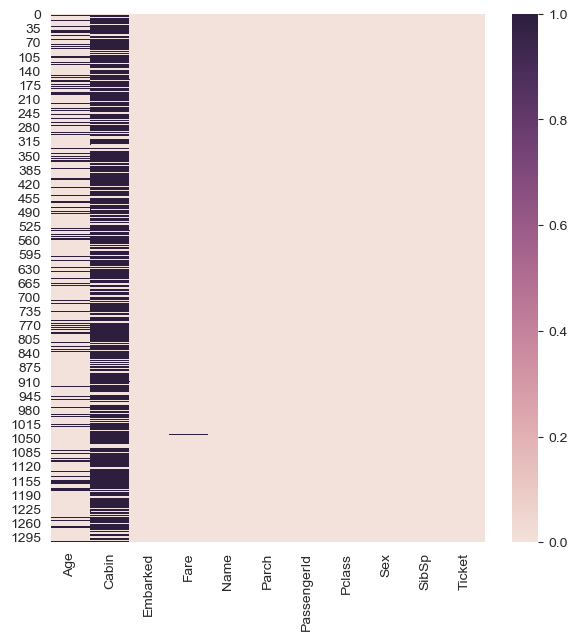

In [408]:
plt.figure(figsize=(7,7), dpi=100)
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
sns.heatmap(df.isnull(), cmap=cmap)
plt.show()

### Data Preperation

#### Age

Age >= 1: The passangers age is denoted as a wholenumber 

Age < 1: The passangers age is denoted as a fraction

In [409]:
df["Age"] = pd.to_numeric(df["Age"], downcast='signed')

To be consistent, I decided to only use wholenumbers. 

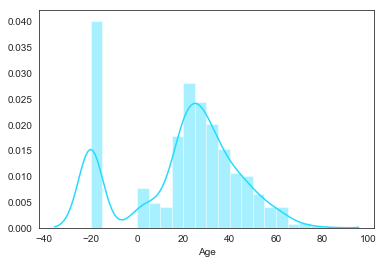

In [410]:
figure = df["Age"].fillna("-20")

figure = figure.astype(int)
sns.distplot(figure)
plt.show()

The distribution of the Age variable is slightly skewed to the right. My first thought was that the skew was caused by missing values for children & teenagers. 

In [411]:
df[19:20]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket
19,NaN,NaN,C,7.225,"Masselmani, Mrs. Fatima",0,20,3,female,0,2649


Examining the Age variable and the Name variable, we can see that missing values occure for married people. Hence the skew is not single handedly attributed to missing values for children & teenagers. 

In [412]:
s = df.Age.value_counts(normalize=True)

missing = df['Age'].isnull()
df.loc[missing,'Age'] = np.random.choice(s.index, size=len(df[missing]),p=s.values)

As I can't find a single cause for why the Age variable has missing observations, I fill the missing values according to the distribution. In reality, age should not be normally distributed; there are always going to be more people at the low end then the high end, and no one is below 0. The reason for the spike in the youngest children might be because it's impractical for mothers to leave their children alone at home. 

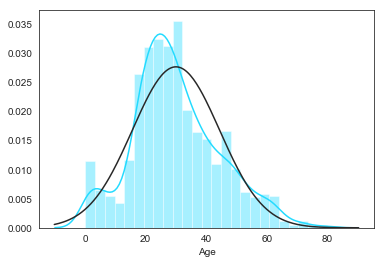

In [413]:
sns.distplot(df["Age"], fit=stats.norm)
plt.show()

#### Fare

The fare is the fee paid by a passanger for the use of transportation. Only one Fare observation is missing for the entire dataset.

In [414]:
df["Fare"].isnull().sum()

1

In [415]:
df[["Fare", "Name", "Pclass"]][1043:1044]

,Fare,Name,Pclass
1043,NaN,"Storey, Mr. Thomas",3


I don't know why Mr Thomas Storey didn't pay (or why the value is missing). I will fill his missing fare value with the median fair value for his corresponding class (Pclass). Keep in mind that we should avoid cheating by googling his name.

In [416]:
df["Fare"] = df.groupby("Pclass")["Fare"].transform(lambda x: x.fillna(x.median()))
df[["Fare", "Pclass"]][1040:1045]

,Fare,Pclass
1040,26.0000,2
1041,83.1583,1
1042,7.8958,3
1043,8.0500,3
1044,12.1833,3


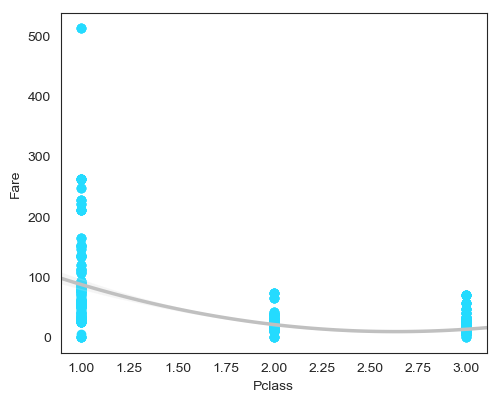

In [417]:
plt.figure(figsize=(5.5,4.5), dpi=100)
plt.scatter(df["Pclass"],df["Fare"])
plot1 = sns.regplot("Pclass", "Fare", data=df, color="silver", scatter=False, order=2, line_kws={"lw":2.5});
plt.show()

In the scatter plot we can observe one outlier for the Fare variable

In [418]:
df["Fare"].loc[df['Fare'] > 500] = 300

I convert the outlier from 500 to 300. 

#### Parch & SibSp

Parch represents the number of parents or children aboard and SibSp represent the number of family relationships aboard. These two variables can be combined into one variable that measures family size.

In [419]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
traindf['FamilySize'] = traindf['SibSp'] + traindf['Parch'] + 1

traindf[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


A variable that measures if a person is alone or not can be created from the FamilySize variable. 

In [420]:
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

traindf['IsAlone'] = 0
traindf.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

traindf[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


##### Name

In [421]:
df['Title'] = df["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(df['Title'], df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,4
Countess,1,0
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2


I use regular expression to clean the title variable. 

In [422]:
traindf['Title'] = traindf["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
traindf['Title'] = traindf['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', \
                                   'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

In [423]:
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', \
                                   'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

In [424]:
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

In [425]:
traindf['Title'] = traindf['Title'].replace('Mlle', 'Miss')
traindf['Title'] = traindf['Title'].replace('Ms', 'Miss')
traindf['Title'] = traindf['Title'].replace('Mme', 'Mrs')

I extract the passangers title from their name and group the title

In [426]:
df["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [427]:
df["Title"] = df["Title"].fillna("Rare")

In [428]:
pd.crosstab(df['Title'], df['Sex'])

Sex,female,male
Title,,
Master,0,61
Miss,264,0
Mr,0,757
Mrs,198,0
Rare,4,25


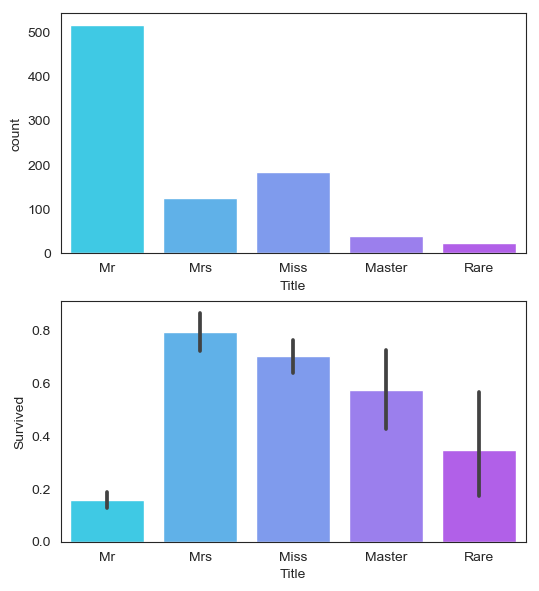

In [429]:
sns.set_style("white")
fx, axes = plt.subplots(2, 1, num=None, figsize=(6, 7), dpi=100)
fig1_title = sns.countplot(data=traindf, x='Title', ax=axes[0])
fig2_title = sns.barplot(data=traindf, x='Title',y='Survived', ax=axes[1])

#### Embarked

Embark represents port of embarkation and should take on three values; C for Cherbourg, Q for Queenstown and S for Southampton.

In [430]:
df["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [431]:
df["Embarked"].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [432]:
df["Embarked"].replace(0, np.nan, inplace=True)

In [433]:
df["Embarked"] = df["Embarked"].fillna("S")

I fill the missing observations with the most common port of embarkation

In [434]:
df["Embarked"].unique()

array(['S', 'C', 'Q'], dtype=object)

In [435]:
traindf["Embarked"] = traindf["Embarked"].fillna("S")
pd.crosstab(traindf['Embarked'], traindf['Survived'])

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,219


#### Cabin

The Cabin variable represent the cabin number.

In [436]:
df["Cabin"].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [437]:
df["Cabin"].isnull().sum()

1014

In [438]:
def clean_cabin(df):
    try:
        return df[0]
    except TypeError:
        return "None"
    
df["Cabin"] = df.Cabin.apply(clean_cabin)

Change the null to "None"

In [439]:
df["Cabin"].value_counts().sort_values(ascending=True)

T          1
G          5
F         21
A         22
E         41
D         46
B         65
C         94
None    1014
Name: Cabin, dtype: int64

In [440]:
df[339:340]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,FamilySize,IsAlone,Title
339,45.0,T,S,35.5,"Blackwell, Mr. Stephen Weart",0,340,1,male,0,113784,1,1,Mr


One could imagen that first class had the top decks (A-E), second class had (D-F), and third class had (E-G). If the case, Pclass should match the order. Only one passanger is located in cabin T, which might suggest that T represents the tennis court. 

In [441]:
df["Cabin"].loc[df["Cabin"] == "A"] = 1
df["Cabin"].loc[df["Cabin"] == "B"] = 2
df["Cabin"].loc[df["Cabin"] == "C"] = 3
df["Cabin"].loc[df["Cabin"] == "D"] = 4
df["Cabin"].loc[df["Cabin"] == "E"] = 5
df["Cabin"].loc[df["Cabin"] == "F"] = 6
df["Cabin"].loc[df["Cabin"] == "G"] = 7

df["Cabin"].loc[df["Cabin"] == "T"] = 9
df["Cabin"].loc[df["Cabin"] == "None"] = 10

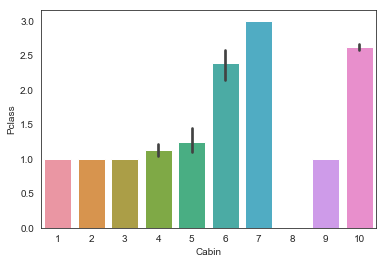

In [442]:
sns.set_style("white")
sns.barplot(y = df["Pclass"], x = df["Cabin"], order=[1,2,3,4,5,6,7,8,9,10])
plt.show()

Most of the missing observations (#10) are from people of middle class or lower class. The single person in Cabin T (#9) is upper class which makes sense assuming Cabin T is the tennis court. 

In [443]:
pd.crosstab(df['Cabin'], df['Pclass'])

Pclass,1,2,3
Cabin,,,
1,22,0,0
2,65,0,0
3,94,0,0
4,40,6,0
5,34,4,3
6,0,13,8
7,0,0,5
9,1,0,0
10,67,254,693


In [444]:
df["Cabin"].replace(10, np.nan, inplace=True)

In [445]:
df["Cabin"] = df.groupby("Pclass")["Cabin"].transform(lambda x: x.fillna(x.ffill()))
df["Cabin"] = df.groupby("Pclass")["Cabin"].transform(lambda x: x.fillna(x.bfill()))

One might improve the final score by filling the missing observation after the distributon but ffill and bfill works as a quick fix.

In [446]:
df["Cabin"].value_counts()

6.0    418
5.0    339
7.0    251
3.0    119
2.0     84
4.0     66
1.0     31
9.0      1
Name: Cabin, dtype: int64

#### Sex

Convert the sex variable to a dummy variable. If male = 1, If female = 0

In [447]:
df["Sex"].loc[df["Sex"]== "male"] = 1
df["Sex"].loc[df["Sex"]== "female"] = 0

traindf["Sex"].loc[traindf["Sex"]== "male"] = 1
traindf["Sex"].loc[traindf["Sex"]== "female"] = 0

#### Check

Once again, check for missing values left

In [448]:
df.isnull().sum()

Age            0
Cabin          0
Embarked       0
Fare           0
Name           0
Parch          0
PassengerId    0
Pclass         0
Sex            0
SibSp          0
Ticket         0
FamilySize     0
IsAlone        0
Title          0
dtype: int64

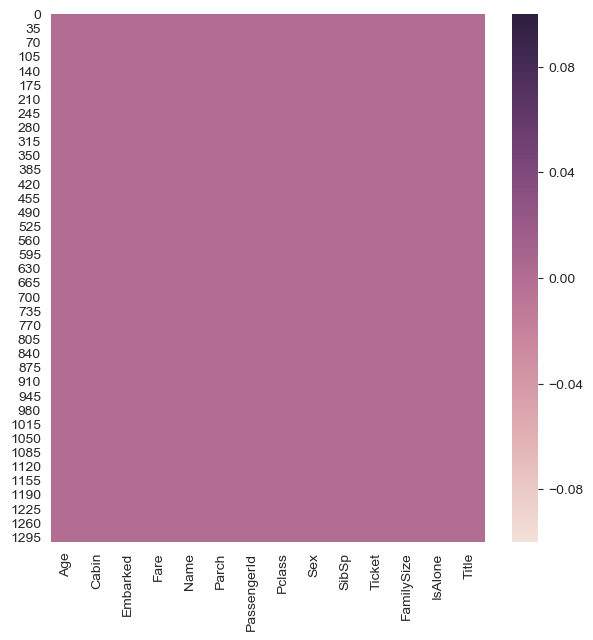

In [449]:
plt.figure(figsize=(7,7), dpi=100)
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
sns.heatmap(df.isnull(), cmap=cmap)#, cmap="BuPu", linewidth=0.07)
plt.show()

In [450]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,FamilySize,IsAlone,Title
0,22.0,7.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,1,A/5 21171,2,0,Mr
1,38.0,3.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,PC 17599,2,0,Mrs
2,26.0,7.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,0,STON/O2. 3101282,1,1,Miss
3,35.0,3.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,113803,2,0,Mrs
4,35.0,7.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,1,0,373450,1,1,Mr


In [451]:
df1 = df[["Age", "Cabin", "Embarked", "Fare", "Parch", "Pclass", "Sex",  "SibSp" , "FamilySize" ,"IsAlone", "Title" ]]
df2 = pd.get_dummies(df1)
df2.head()

,Age,Cabin,Fare,Parch,Pclass,Sex,SibSp,FamilySize,IsAlone,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,22.0,7.0,7.2500,0,3,1,1,2,0,0,0,1,0,0,1,0,0
1,38.0,3.0,71.2833,0,1,0,1,2,0,1,0,0,0,0,0,1,0
2,26.0,7.0,7.9250,0,3,0,0,1,1,0,0,1,0,1,0,0,0
3,35.0,3.0,53.1000,0,1,0,1,2,0,0,0,1,0,0,0,1,0
4,35.0,7.0,8.0500,0,3,1,0,1,1,0,0,1,0,0,1,0,0


Class & Cabin is ordinal, no reason to one hot encode.

In [452]:
df2.describe()

,Age,Cabin,Fare,Parch,Pclass,Sex,SibSp,FamilySize,IsAlone,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,30.018342,5.186402,32.627364,0.385027,2.294882,0.644003,0.498854,1.883881,0.603514,0.206264,0.093965,0.699771,0.046600,0.201681,0.578304,0.151261,0.022154
std,14.403154,1.560825,46.826550,0.865560,0.837836,0.478997,1.041658,1.583639,0.489354,0.404777,0.291891,0.458533,0.210862,0.401408,0.494019,0.358440,0.147242
min,0.170000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,5.000000,7.895800,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28.000000,6.000000,14.454200,0.000000,3.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,39.000000,6.000000,31.275000,0.000000,3.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,80.000000,9.000000,300.000000,9.000000,3.000000,1.000000,8.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [453]:
ntrain

891

In [454]:
train = df2.iloc[:ntrain]
test = df2.iloc[ntrain:]

### Model

In [455]:
model = RandomForestClassifier(n_estimators=120)
model.fit(train, y_train)

score_tr = model.score(train, y_train)
print(score_tr)

0.9955106621773289


Overfitting

In [456]:
model.feature_importances_

array([0.20329893, 0.07911053, 0.19479813, 0.01774409, 0.06397302,
       0.11275036, 0.02824437, 0.04843113, 0.00821597, 0.01165874,
       0.00893096, 0.01459727, 0.00963014, 0.03114543, 0.12230835,
       0.03628065, 0.00888193])

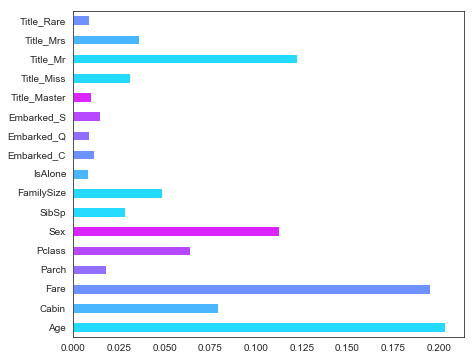

In [457]:
feature_importances = pd.Series(model.feature_importances_, index=train.columns)
feature_importances.plot(kind="barh", figsize=(7,6));

In [458]:
X_train = train.values

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

K fold cross validation

In [459]:
kfold = StratifiedKFold(n_splits=10)

I compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.

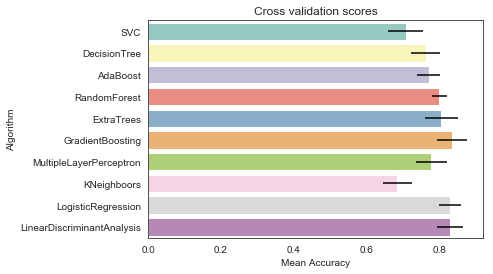

In [460]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=8))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

### Meta Modeling

I decided to choose the SVC, AdaBoost, RandomForest , ExtraTrees and the GradientBoosting classifiers for the ensemble modeling. I performed a grid search optimization for the classifiers. Set "n_jobs" according to your computers computational capacity. A higher "n_jobs" tend to result in a better final score. 

#### Adaboost

In [461]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
                "algorithm" : ["SAMME","SAMME.R"],
                "n_estimators" :[1,2],
                "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 448 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 1120 out of 1120 | elapsed:    2.6s finished


In [462]:
gsadaDTC.best_score_

0.797979797979798

#### ExtraTrees 

In [463]:
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   15.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   43.0s
[Parallel(n_jobs=8)]: Done 540 out of 540 | elapsed:   54.7s finished


0.8338945005611672

#### RFC Parameters tunning 

In [464]:
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   19.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   53.4s
[Parallel(n_jobs=8)]: Done 540 out of 540 | elapsed:  1.2min finished


0.8395061728395061

#### Gradient boosting tunning

In [465]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:   13.5s
[Parallel(n_jobs=8)]: Done 720 out of 720 | elapsed:   27.1s finished


0.8237934904601572

##### SVC classifier

In [466]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                   'gamma': [ 0.001, 0.01, 0.1, 1],
                   'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gsSVMC.fit(X_train,y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   19.4s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:   40.1s finished


0.8092031425364759

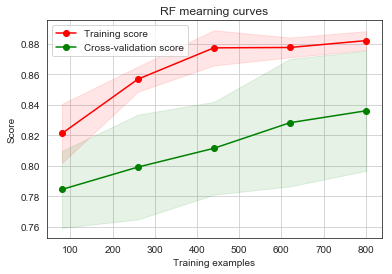

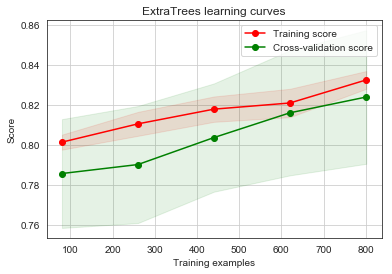

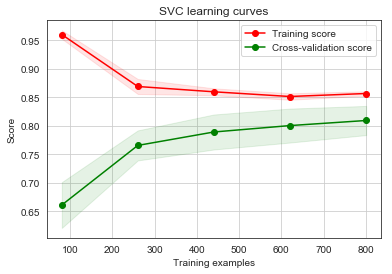

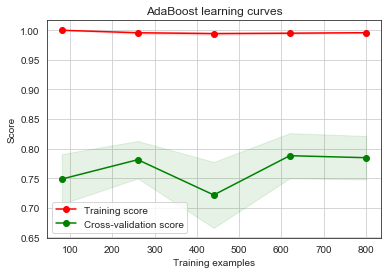

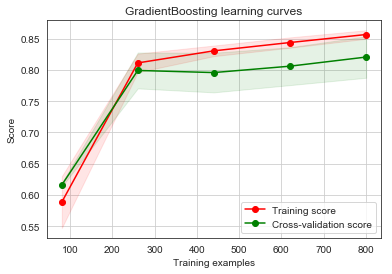

In [467]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,y_train,cv=kfold)

Learning curves are used to examine the overfitting effect. GradientBoosting & Adaboost classifiers tend to overfit the training set. GradientBoosting & Adaboost could perform better with a larger training set. 

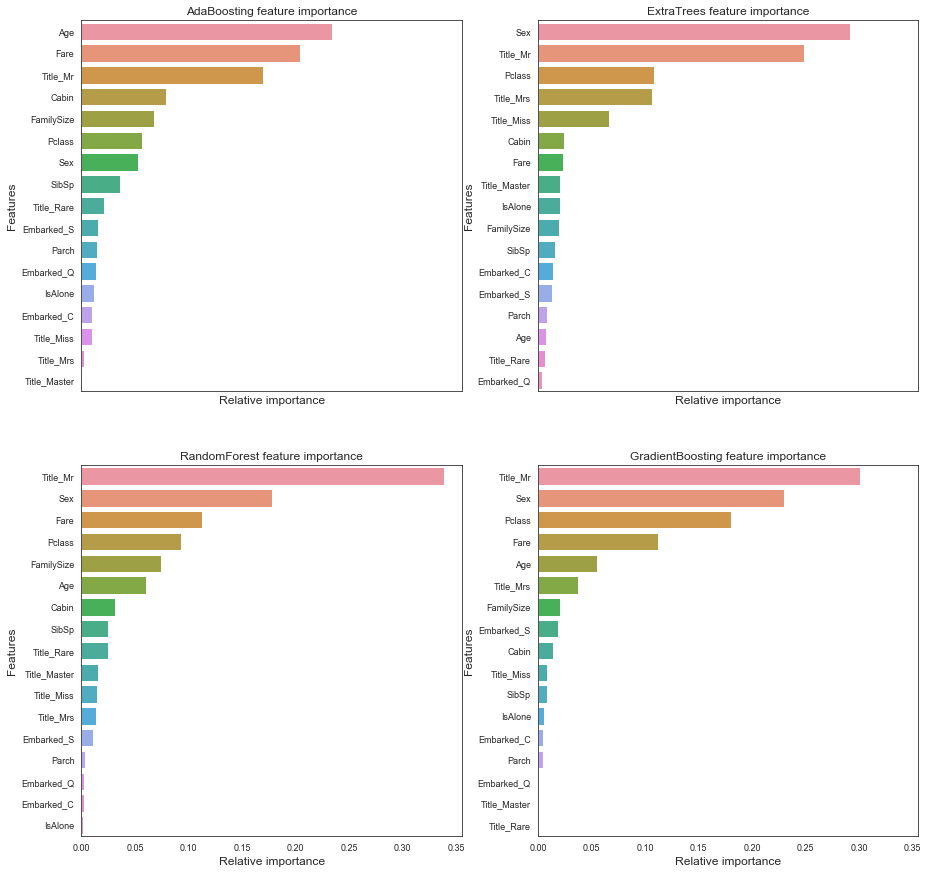

In [468]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

The four classifiers have different top features according to the relative importance. Nevertheless, they share some common important features for the classification , for example Sex, Fare, Title_Mr, Cabin and Age.

    -Fare & Cabin refer to the general social standing of passengers 
    -Sex & Title_Mr refers to the gender
    -Age & Title_Master refers to the age of the passenger.
    -Family size and IsAlone refers to the size of the passengers family.

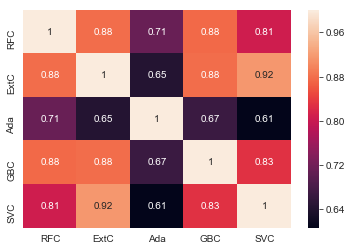

In [469]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)
#ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_GBC],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True)

In [470]:
#votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
#('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('gbc',GBC_best)], voting='soft', n_jobs=8)

votingC = votingC.fit(X_train, y_train)

In [471]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([testdf_ID,test_Survived],axis=1)

results.to_csv("SubmissionFile.csv",index=False)